# Predicting Reddit Comment Score with Keras Deep Learning
> In this post we will be using Tensorflow and utilizing the high level API  Keras to predict comments scores on the popular web forum Reddit.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter, pandas, keras, reddit, deep-learning]
- image: images/reddit-comment-score.png

<p>The code for this project can be found <a href="https://github.com/gardnmi/reddit_score_prediction/blob/master/model.ipynb">here.</a></p>

<hr />
<h3 id="imports">Imports</h3>

In [1]:
import os
import requests
import json
import numpy as np
import pandas as pd
import zstandard as zstd
import tensorflow as tf
import seaborn as sns
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding, LSTM, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import Constant

# Display Options
pd.options.display.float_format = '{:,.2f}'.format

#Variables
MAX_SEQUENCE_LENGTH = 700
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100

<p> The main libraries used for this project are Tensorflow and the high level API Keras which enable fast prototyping for projects and research.  Tensorflow has integrated Keras into its library and can now be accessed directly from Tensorflow.  We also import Pandas, Numpy, and Scikit-Learn to assist in our data wrangling </p>

<hr />
<h3 id="data-wrangling">Data Wrangling</h3>




<p> There are several ways to grab comment data from Reddit but I found the fastest and most comprehensive way was to use <a href="https://files.pushshift.io/reddit/comments/">pushift.</a> which has already done a bulk of the work for us.  Each file contains comments made on Reddit for a particular time period.  Since each file contains millions of comments we are only going to download the most recent file. </p>



In [0]:
# Extract Data from zst file
# https://www.reddit.com/r/pushshift/comments/ajmcc0/information_and_code_examples_on_how_to_use_the/

fields = ['body', 'created_utc', 'id', 'is_submitter', 'link_id', 'score', 'subreddit_id', 'subreddit'] 

with open("RC_2019-02.zst", 'rb') as fh:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(fh) as reader:
        previous_line = ""
        count = 1
        while True:
            chunk = reader.read(2**24)
            if not chunk:
                break
                
            string_data = chunk.decode('utf-8')
            lines = string_data.split("\n")
            comments = []
            
            for i, line in enumerate(lines[:-1]):
                if i == 0:
                    line = previous_line + line
                object = json.loads(line)
                    
                if object['body'] in ['[deleted]', '[removed]'] or \
                    object['parent_id'].startswith('t1') or \ 
                    object['subreddit'].lower() not in ['politics']:
                    
                    pass
                else:
                    object = dict((k, object[k]) for k in fields if k in object)
                    
                    comments.append(object)
                    
            df = pd.DataFrame(comments)
            
            df.to_csv(f'raw-data//{count}_comments.csv', index=False)
            count += 1         
              
            previous_line = lines[-1]

<p> The zst file is too big to read into memory all at once.  The above code loops through the file from pushift and stores chunks of comments into individual csv files.  In order to further reduce the size we also limit the comments to the politics subreddit.  The politics subreddit has a consistent narrative therefore it might not be as eratic as other subreddits when it comes to comment score. </p>

In [0]:
url = 'https://api.pushshift.io/reddit/search/submission/?ids='

for file in os.listdir(r'raw-data/'):
    link_id = []
    link_created_utc = []

    df = pd.read_csv(f'raw-data/{file}')
    link_ids = df['link_id'].str.split('_', expand=True)[1].unique().tolist()
    split_link_ids = np.array_split(link_ids, 5)

    try:

        for ids in split_link_ids:

            r = requests.get(f'{url}{",".join(ids)}')

            package_json = r.json()

            data = package_json['data']

            for field in data:
                link_id.append('t3_' + field['id'])
                link_created_utc.append(field['created_utc'])

        data = list(zip(link_id, link_created_utc))

        link_df = pd.DataFrame(data, columns=['link_id', 'link_created_utc'])

        new_df = df.merge(link_df, on='link_id', how='inner')

        new_df.to_csv(f'comb-data/{file}', index=False)

    except:
        print('failed')
        pass

<p>The comment data is missing the submission timestamp for which the comment belongs too. Time elapsed since submission is a critical factor in determining comment score so we need this information. Fortunately, the same site that provided the comment data also has an API we can leverage to fill in our missing data.</p>

<p>The above script opens up each csv file that was created earlier and passes the post id (link_id) to the API in which returns the post timestamp. We then save the csv file with our new field..</p>

In [ ]:
filepaths = [f'comb-data/{file}' for file in os.listdir(r'comb-data/')]
df = pd.concat(map(pd.read_csv, filepaths))
df = df.reset_index(drop=True)
df.to_csv('reddit_data.csv', index=False)

<p>Finally we take the individual csv files and merge them into a single csv file.  We should try and reduce as much complexity as we can.  You could feed the individual  csv files to Keras model but if you don't have to then don't do it.</p>

<hr />
<h3 id="data-exploration">Data Exploration</h3>

In [45]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# df = pd.read_csv(r'gdrive/My Drive/Projects/reddit-score-pred/reddit_data.csv')

# embeddings_index = {}
# with open('gdrive/My Drive/Projects/reddit-score-pred/glove.6B.100d.txt', encoding="utf8") as f:
#     for line in f:
#         word, coefs = line.split(maxsplit=1)
#         coefs = np.fromstring(coefs, 'f', sep=' ')
#         embeddings_index[word] = coefs

In [2]:
df = pd.read_csv('reddit_data.csv')
df = df[df.subreddit == 'politics']

In [3]:
df.head()

,body,created_utc,id,is_submitter,link_id,score,subreddit,subreddit_id,link_created_utc
3,I'll be honest I'm not a fan of this. \n\nI re...,1549297521,efqd1ln,False,t3_an1zxq,-10,politics,t5_2cneq,1549289373
4,Trump curse incoming!!!,1549297533,efqd26p,False,t3_an1zxq,1,politics,t5_2cneq,1549289373
5,How is he going to get cold Chinese food at th...,1549297561,efqd3l0,False,t3_an1zxq,2,politics,t5_2cneq,1549289373
6,The one backbencher for the Pats likes Obama. ...,1549297594,efqd57i,False,t3_an1zxq,-12,politics,t5_2cneq,1549289373
7,What's Obama up to these days?,1549297606,efqd5ri,False,t3_an1zxq,1,politics,t5_2cneq,1549289373


In [4]:
df.body = df.body.astype(str)
print('Comment Metrics')
print(f'Mean: {df.body.map(len).mean():.0f}')
print(f'Min: {df.body.map(len).min():.0f}')
print(f'Max: {df.body.map(len).max():.0f}')
print(f'Std: {df.body.map(len).std():.0f}')

Comment Metrics
Mean: 195
Min: 1
Max: 10123
Std: 304


In [5]:
df.score.describe()

count   506,386.00
mean         19.50
std         213.89
min        -491.00
25%           1.00
50%           2.00
75%           7.00
max      21,364.00
Name: score, dtype: float64

<p>Our dataset contains over 500,000 comments.  When looking at the distribution of the scores it appears we may have some issues as it appears we don't have a normal distribution.  Below we'll plot some charts of the distribution and various normalization techniques.</p>

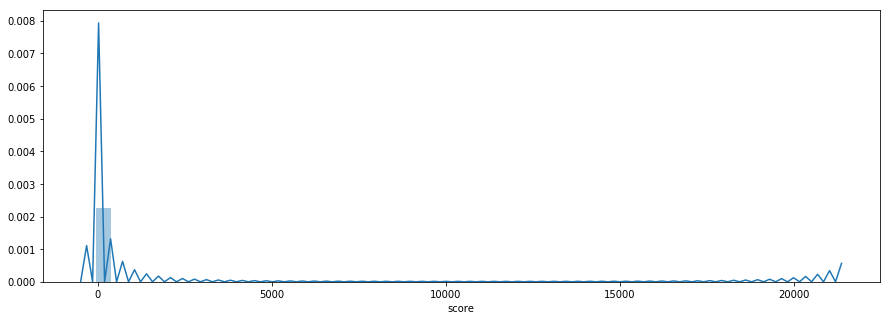

In [6]:
plt.figure(figsize=(15, 5))
sns.distplot(df.score);

C:\Users\Mike\.conda\envs\reddit-score-pred\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mike\.conda\envs\reddit-score-pred\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


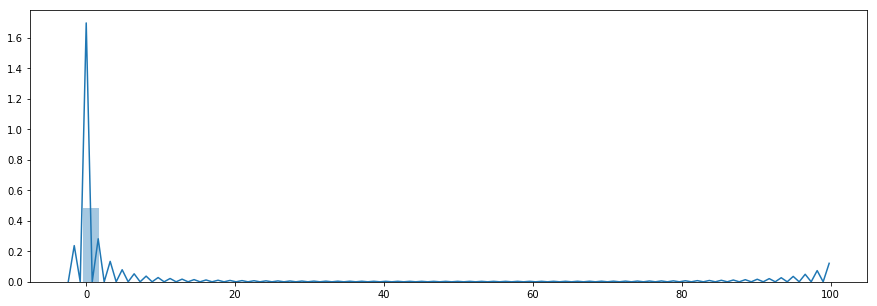

In [7]:
scaler = StandardScaler()
scores = scaler.fit_transform(df.score.values.reshape(-1,1))

plt.figure(figsize=(15, 5))
sns.distplot(scores);

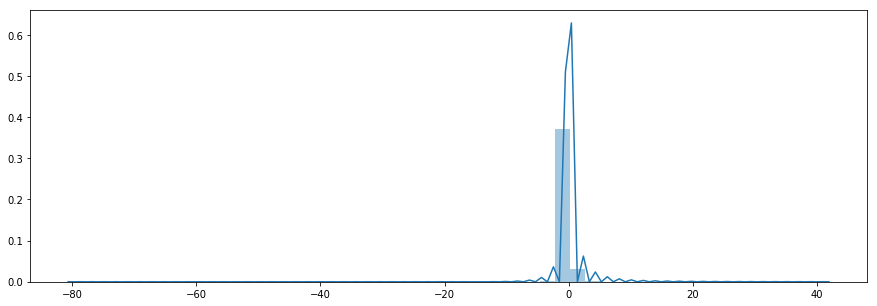

In [8]:
from sklearn.preprocessing import power_transform
scores = power_transform(df.score.values.reshape(-1,1), method='yeo-johnson')

plt.figure(figsize=(15, 5))
sns.distplot(scores);

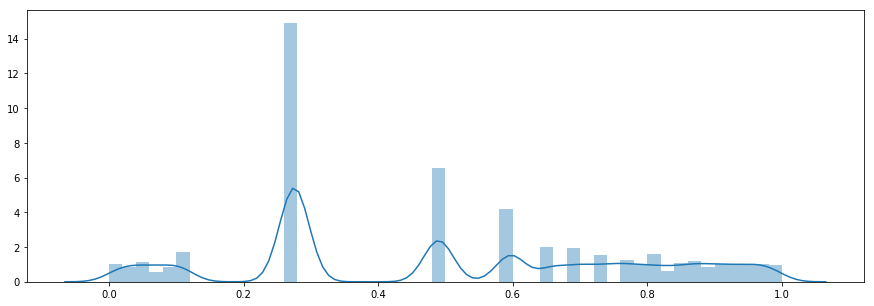

In [9]:
from sklearn.preprocessing import quantile_transform
scores = quantile_transform(df.score.values.reshape(-1,1), n_quantiles=99, random_state=0)
plt.figure(figsize=(15, 5))
sns.distplot(scores);

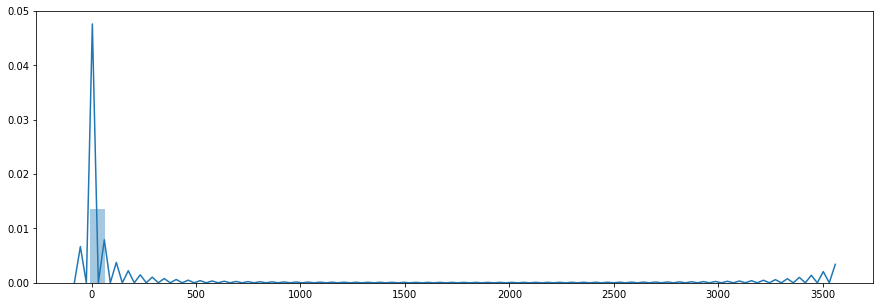

In [10]:
from sklearn.preprocessing import robust_scale
scores = robust_scale(df.score.values.reshape(-1,1))

plt.figure(figsize=(15, 5))
sns.distplot(scores);

In [11]:
df.score.quantile(np.linspace(.04, 1, 24, 0))

0.04   -6.00
0.08   -1.00
0.12    0.00
0.16    1.00
0.20    1.00
0.24    1.00
0.28    1.00
0.32    1.00
0.36    1.00
0.40    1.00
0.44    2.00
0.48    2.00
0.52    2.00
0.56    3.00
0.60    3.00
0.64    4.00
0.68    5.00
0.72    6.00
0.76    7.00
0.80    9.00
0.84   12.00
0.88   16.00
0.92   24.00
0.96   48.00
Name: score, dtype: float64

<p>After exploring the distribution it appears that we may have some issues if we try to predict the score using regression.  A better option would be to bin the data into categorical groups and use a classification model to predict groups of data.</p>

In [12]:
pd.cut(
    df.score, [-10000, 0, 1, 10, 50, 10000],
    labels=['Downvoted', 'No Votes', '2-10 Votes', '11-50 Votes', '50+ Votes']).value_counts()

2-10 Votes     203917
No Votes       151028
11-50 Votes     69650
Downvoted       62430
50+ Votes       19321
Name: score, dtype: int64

In [13]:
df['score_category'] = pd.cut(
    df.score, [-100000, 0, 1, 10, 50, 100000],
    labels=['Downvoted', 'No Votes', '2-10 Votes', '11-50 Votes', '50+ Votes'])

In [14]:
df.score_category.cat.categories

Index(['Downvoted', 'No Votes', '2-10 Votes', '11-50 Votes', '50+ Votes'], dtype='object')

In [15]:
pd.concat([df.score_category, df.score_category.cat.codes], axis=1).head(10)

,score_category,0
3,Downvoted,0
4,No Votes,1
5,2-10 Votes,2
6,Downvoted,0
7,No Votes,1
8,2-10 Votes,2
9,11-50 Votes,3
10,No Votes,1
11,Downvoted,0
12,2-10 Votes,2


<p>We utilize the pandas cut method to group our data into 5 groups ('Downvoted', 'No Votes', '2-10 Votes', '11-50 Votes', '50+ Votes').  You can access a numerical representation of the category by callin the <code>.cat.codes</code> method.</p>

<hr />
<h3 id="data-exploration">Data Preperation</h3>

In [16]:
df['time_lapsed'] = df['created_utc'] - df['link_created_utc'] 

<p>The only feature engineering I did for this project is to create a field to record the time lapsed between the submission timestamp and comment timestamp.  However, it isn't a bad idea to spend time here and feature engineer more fields such as minute, hour, day of week, month, etc.</p>

In [17]:
#Importing Pretrained Embeddings

embeddings_index = {}
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
        
        
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df.body)

sequences = tokenizer.texts_to_sequences(df.body)
word_index = tokenizer.word_index
comments = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare Embedding Matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


print(f'Found {len(word_index):,} unique tokens.')

Found 142,859 unique tokens.


<p>To prep our comments for our Deep Learning model we will be tokenizing (indexing) each unique word found in all our comments.  We then use a technique called Embedding to assign a vector of numbers to each unique token.  The embedding values we are using are pretrained values and you can read more about them in this  <a href="https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html">keras blog post.</a></p>

In [29]:
pd.Series(word_index).head(10)

the      1
to       2
a        3
and      4
of       5
this     6
is       7
in       8
i        9
for     10
dtype: int64

In [38]:
comments

array([[   0,    0,    0, ...,  477, 1488,  130],
       [   0,    0,    0, ...,    0,   27, 4701],
       [   0,    0,    0, ...,   21,  508,  168],
       ...,
       [   0,    0,    0, ...,  757,   79, 1019],
       [   0,    0,    0, ...,    3, 2087, 1116],
       [   0,    0,    0, ...,    8, 1171,   11]])

In [52]:
embedding_matrix[word_index['trump']]

array([-0.15730999, -0.75502998,  0.36844999, -0.18957999, -0.16896001,
       -0.23157001, -0.22657999, -0.30186   ,  0.24372   ,  0.61896002,
        0.58995003,  0.047638  , -0.055164  , -0.70210999,  0.22084001,
       -0.69231999,  0.49419001,  1.42850006, -0.25362   ,  0.20031001,
       -0.26192001,  0.05315   , -0.048418  , -0.44982001,  0.54644001,
       -0.014645  , -0.015531  , -0.61197001, -0.91964   , -0.75279999,
        0.64842999,  1.0934    ,  0.052682  ,  0.33344999,  0.10532   ,
        0.59517002,  0.023104  , -0.37105   ,  0.29749   , -0.23683   ,
        0.079566  , -0.10326   ,  0.35885   , -0.28935   , -0.19881   ,
        0.22908001, -0.061435  ,  0.56127   , -0.017115  , -0.32868001,
       -0.78416997, -0.49375001,  0.34944001,  0.16278   , -0.061168  ,
       -1.31060004,  0.39151999,  0.124     , -0.20873   , -0.18472999,
       -0.56184   ,  0.55693001,  0.012114  , -0.54544997, -0.31409001,
        0.1       ,  0.31542999,  0.74756998, -0.47734001, -0.18

<p>Above we can see each word token, the tokens in an array representing our comment, and the embedding for the word "trump".</p>

In [18]:
# Extracting Features and Target (Score)
features = df.drop(['score', 'score_category', 'body', 'id', 'link_id', 'subreddit', 'subreddit_id'], axis=1)
category = df['score_category'].cat.codes

# Scaling Features for Model
scaler = StandardScaler()
features = scaler.fit_transform(features)

C:\Users\Mike\.conda\envs\reddit-score-pred\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Mike\.conda\envs\reddit-score-pred\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


<p>We create a features column by dropping the fields we won't be using.   We also create a separate  array for the "score categories" which is what we are trying to predict.  Finally, we scale our features using the scikit-learn "StandardScaler" method.  Scaling our data makes it a lot easier for our model to optimize our loss function.  There is also a third array "comments" not shown above that is an additional feature array that we will be feeding to the model.</p>

In [19]:
# Train, Test, Splint
comments_train, comments_val, feature_train, feature_val, category_train, category_val = train_test_split(
    comments, features, category, test_size=0.33, random_state=42)

<p>Finally we split our data into a Training set and Validation set using scikit-learn "train_test_split" function.  We will be creating a multi-input and single output Keras model so we have two sets of feature data (comments and features).</p>

<hr />
<h3 id="model-creation">Model Creation</h3>

In [20]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False)

<p>The first thing we do is setup our embedding layer.  You can find out more about the layer above in this <a href="https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html"> Keras Blog. </a>  </p>

In [21]:
# Creating Keras Model

comments_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
embedded_sequences = embedding_layer(comments_input)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(.3)(x)
# comments_prediction = Dense(5, activation='softmax')(x)
comments_output = Dense(128, activation='relu')(x)

feature_input = Input(shape=(4, ))
x = tf.keras.layers.concatenate([comments_output, feature_input])

# We stack a deep densely-connected network on top
x = Dense(250, activation='relu')(x)
x = Dropout(.3)(x)
x = Dense(125, activation='relu')(x)
x = Dropout(.3)(x)

# And finally we add the main logistic regression layer
final_prediction = Dense(5, activation='softmax')(x)

<p>For the core of our Keras Model we will be utilizing the Functional API.  It's based on the Multi Input and Multi Output example found on the <a href="https://keras.io/getting-started/functional-api-guide/"> Keras documentation. </a>  The first input feature will be our comments and our second input feature will be the other feature columns</p>

In [22]:
# Initializing and Running Keras Model

model = Model([comments_input, feature_input], [final_prediction])

model.compile(
    loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit([comments_train, feature_train],
          [category_train],
          batch_size=128,
          epochs=100,
          validation_data=([comments_val, feature_val], [category_val]))

<p>The last step is to Initialize our model with the layers we created and define the loss function and gradient descent optimizer.  We can also pass other metrics such as "accuracy" that Keras will track for us.  Finally, we fit the model using the training and validation we created earlier.  Above I have set the epochs to 100 which tells our model to loop through our training dataset 100 times, each time optimizing the weights and bias to reduce our loss.</p>

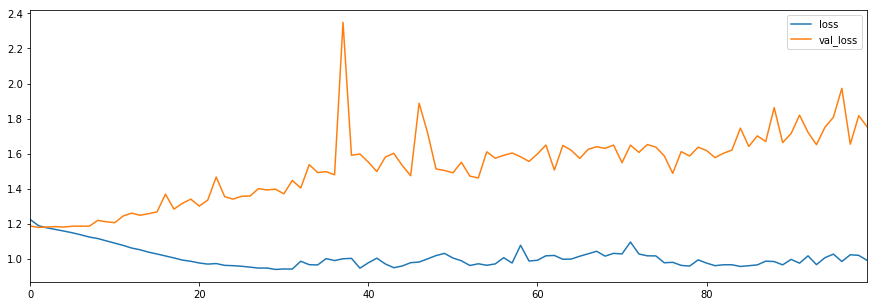

In [56]:
# Graphing Results

pd.DataFrame(model.history.history)[['loss','val_loss']].plot(figsize=(15, 5))

<p>We then graph the results of our loss.  Above you can see that our train loss flattens around 35 epochs and then jumps around.  Our validation loss is best at only 2 or 3 epochs.  The validation loss gets worse the more we overfit our model to our training data.</p>

In [0]:
model.save('reddit_score.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
model = load_model('reddit_score.h5')

<p>If we want to at this point we can choose to save our model using the "save" method.  We can also load the saved model just as easily.</p>

In [23]:
model = Model([comments_input, feature_input], [final_prediction])

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit([comments_train, feature_train],
          [category_train],
          batch_size=128,
          epochs=3,
          validation_data=([comments_val, feature_val], [category_val]))

Train on 339278 samples, validate on 167108 samples
Epoch 1/3
339278/339278 [==============================] - 1172s 3ms/sample - loss: 1.2279 - accuracy: 0.4943 - val_loss: 1.1993 - val_accuracy: 0.4988
Epoch 2/3
339278/339278 [==============================] - 1143s 3ms/sample - loss: 1.2009 - accuracy: 0.5007 - val_loss: 1.1884 - val_accuracy: 0.5014
Epoch 3/3
339278/339278 [==============================] - 1173s 3ms/sample - loss: 1.1957 - accuracy: 0.5020 - val_loss: 1.1991 - val_accuracy: 0.4993


In [24]:
model.history.history

{'loss': [1.2278857953891122, 1.2008990119142613, 1.1957352068886913],
 'accuracy': [0.4942643, 0.5007133, 0.50197774],
 'val_loss': [1.1993256573285909, 1.1884006263822988, 1.1991039581740772],
 'val_accuracy': [0.49880317, 0.50144815, 0.4993238]}

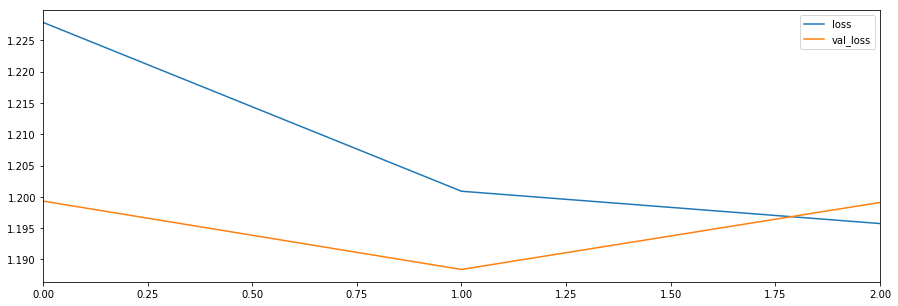

In [25]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot(figsize=(15, 5))

<p>Since our model appears to do best at around 3 epochs I chose to reset the model and re-fit it with just 3 epochs. </p> 

<hr />
<h3 id="model-evaluation">Model Evaluation</h3>

In [26]:
predictions = model.predict([comments_val, feature_val])
prediction_ = np.argmax(predictions, axis = 1)

<p>To further evaluate the model we need to make a set of predictions.  Since I didn't create a holdout set of data I went ahead and made predictions on our validation data.  The predict method returns an array of probabilities of each "score category".  In order to choose the score with the highest probability, we leverage numpy's argmax method to grab the index of the highest probability.</p>

In [27]:
confusion_matrix(category_val, prediction_)

array([[ 1082,  7290, 12311,     0,     0],
       [  412, 28688, 20640,     4,     1],
       [  621, 12996, 53664,     3,     1],
       [  246,  1031, 21744,     5,     4],
       [   51,   115,  6191,     6,     2]], dtype=int64)

<p>To visualize our accuracy we use the scikit-learn confusion matrix.  However, it's not very descriptive by itself.</p>

In [28]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

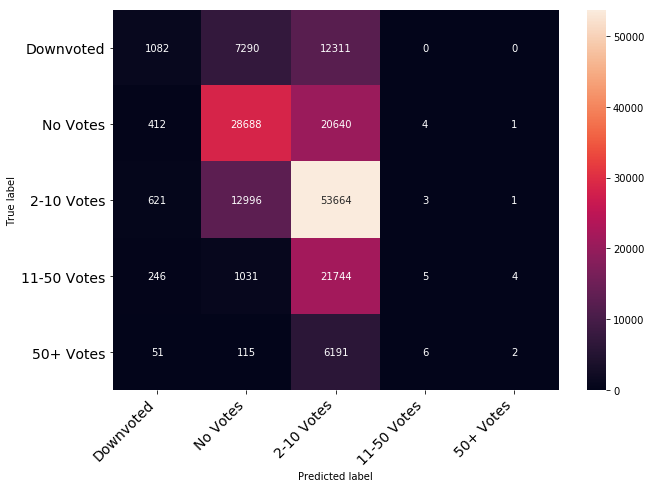

In [29]:
print_confusion_matrix(confusion_matrix(category_val, prediction_), df.score_category.values.unique().tolist());

<p>The above script enhances our confusion matrix by leveraging seaborn.  It provides a much clearer picture of are results.  The code can be found <a href="https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823"> here. </a></p>



In [0]:
results = pd.concat([category_val, df.body], axis=1, join='inner').reset_index(drop=True)
results = pd.concat([results, pd.Series(prediction_)], axis=1)
results.columns = ['Actual', 'Comment', 'Prediction']

In [94]:
results.head()

,Actual,Comment,Prediction
0,2,Does Trump think El Paso is a Republican frien...,1
1,0,The thumbnail is a great representation of Tuc...,1
2,2,So the Emperor went in procession under the ri...,1
3,2,I made a meme: https://youtu.be/D899XSiFt1s,1
4,4,&gt; No president ever worked harder than me (...,0


In [101]:
results[(results.Actual == 4) & (results.Prediction == 0) ].Comment.values

array(['&gt; No president ever worked harder than me (cleaning up the mess I inherited)!\n\n1. What [mess](https://i.imgur.com/aiIOGEh.png)?\n\n2. You created the "crisis" at the border, concerning a group of people that commit less violent crime than the general American public during a time when illegal immigration has been at historic lows for years now. \n\n3. The SCOTUS appointments fell into your lap. \n\n4. The ACA now has popular support from the American people. \n\n5. Most Americans do not want your stupid wall. \n\n6. You have given another huge tax break to wealth individuals and corporations, forcing the rest of us to continue to pay for their avarice. \n\n7. You have alienated our historic partnerships while coddling atrocious dictators. You have bent a knee to a nation (Russia) that has a smaller economy than Texas, California or New York... by ***themselves***. \n\n8. You have spent more time on the golf course and in front of a TV than any modern President. \n\n9. Your

<p>Exploring the results where our model was most wrong is a good way to figure out where we can tweak our model to improve results.  Above I queried comments where our model thought it would be a downvoted comment but the comment ended up with 50+ upvotes.  Another option would be to query results where the model had high confidence in a particular category but was wrong in its prediction.</p>

<hr />
<h3 id="summary">Summary</h3>

<p>Keras is a high level API yet it still offers the flexibility to create dynamic deep learning models.  Our initial results may not be state of the art but predicting comment score is a very complex problem with countless dependencies that could affect it. </p>

Resources:

<ul>
	<li>https://www.johnwittenauer.net/deep-learning-with-keras-structured-time-series/</li>
	<li>https://www.tensorflow.org/alpha/tutorials/keras/feature_columns</li>
	<li>https://realpython.com/python-keras-text-classification/</li>
	<li>https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html</li>
	<li>https://github.com/titu1994/keras-one-cycle</li>
	<li>https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf</li>
	<li>https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1</li>
	<li>https://www.youtube.com/watch?v=FmpDIaiMIeA</li>
	<li>https://end-to-end-machine-learning.teachable.com/courses/how-deep-neural-networks-work/lectures/9533961</li>
	<li>https://api.pushshift.io/reddit/search/submission/?ids=9yuili</li>
	<li>https://github.com/titu1994/keras-one-cycle</li>
	<li>http://colah.github.io/posts/2015-08-Understanding-LSTMs/</li>
	<li>https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models</li>
	<li>http://ruder.io/text-classification-tensorflow-estimators/</li>
	<li>https://www.tensorflow.org/guide/datasets#consuming_csv_data</li>
	<li>https://medium.freecodecamp.org/how-to-transfer-large-files-to-google-colab-and-remote-jupyter-notebooks-26ca252892fa</li>
	<li>https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1</li>
</ul>